# Exploring the distribution of $p$-values

Based on Lukas' suggestion, we look at the distribtuion of $p$-values to see if there's an issue with the breakdown of statistical assumptions underlying the FDR calculation.

In [1]:
from os import path

import re

import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Circle
from matplotlib.cm import get_cmap

import numpy as np

import pandas as pd
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

In [2]:
%matplotlib inline

In [3]:
default_figsize = (5, 3.5)

In [4]:
def extract_psm_data(file, decoy_fn, entrap_fn=None):
    '''
    Takes a Percolator XML results file.
    
    If `entrap_fn is not None` then the returned dataset will contain an
    `entrap` column, which is the result of calling `entrap_fn(dataframe)`.
    
    Return a dataframe of PSM data.
    '''
        
    with open(file) as f:
        tree = ET.parse(f)
    
    ns = '{http://per-colator.com/percolator_out/15}'
        
    info = dict([(e.tag.split('}', 1)[1] if '}' in e.tag else e.tag, e.text) for e in tree.getroot().find(ns+'process_info')])
    
    df = pd.DataFrame(
        [
            dict(
                [
                    ('psm_id', psm.get(ns+'psm_id'))
                   ,('peptide_seq', psm.find(ns+'peptide_seq').get('seq'))
                ]
               +[(e.tag.split('}', 1)[1] if '}' in e.tag else e.tag, e.text) for e in psm if len(e.attrib) == 0]
            )
            for psm in tree.getroot()\
                    .find(ns+'psms')\
                    .findall(ns+'psm')
        ]
    )
    
    df['decoy'] = decoy_fn(df)
    
    if entrap_fn is not None:
        df['entrap'] = entrap_fn(df)
    
    return (df, info)

In [5]:
POSTER_WIDE_PANHUMAN_XML = 'target/data.percv2/poster/wide-panhuman.xml'

POSTER_WIDE_SPECIFIC_XML = 'target/data.percv2/poster/wide-specific.xml'

POSTER_WIDE_ENTRAP_XML = 'target/data.percv2/poster/wide-entrap.xml'

WIDE_LOWFDR_XML = 'target/data.percv2/lowfdr/wide-lowfdr.xml'

In [6]:
decoy_fn = lambda df: df.protein_id.str.match(re.compile('^DECOY_[^;]+(;DECOY_[^;]+)*$'))

In [7]:
analyze_psms = True

extract_fn = extract_psm_data

In [8]:
panhuman_data = extract_fn(POSTER_WIDE_PANHUMAN_XML, decoy_fn)

In [9]:
specific_data = extract_fn(POSTER_WIDE_SPECIFIC_XML, decoy_fn)

In [10]:
lowfdr_data = extract_fn(WIDE_LOWFDR_XML, decoy_fn)

In [11]:
entrap_fn = lambda df:\
    (~df.decoy & df.protein_id.str.match(re.compile('^SHUFFLE_[^;]+(;SHUFFLE_[^;]+)*$')))\
    | (df.decoy & df.protein_id.str.match(re.compile('^DECOY_SHUFFLE_[^;]+(;DECOY_SHUFFLE_[^;]+)*$')))

entrap_data = extract_fn(POSTER_WIDE_ENTRAP_XML, decoy_fn, entrap_fn)

In [12]:
data =   [specific_data, lowfdr_data, entrap_data, panhuman_data]
labels = ['Wide/Specific', 'Wide/Specific (LowFDR)', 'Wide/SS+Entrapment', 'Wide/Pan-Human']

In [13]:
counts = pd.DataFrame([np.float32(info['psms_qlevel']) for (_, info) in data], index=labels, columns=['# PSMs'])

In [14]:
counts

# PSMs
Wide/Specific           391988.0
Wide/Specific (LowFDR)  381629.0
Wide/SS+Entrapment      298016.0
Wide/Pan-Human          339302.0

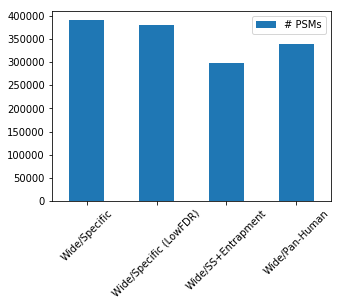

In [15]:
fig,ax = plt.subplots()
counts.plot.bar(ax=ax, rot=45, figsize=default_figsize)
fig.savefig('target/img/counts.pdf', bbox_inches='tight')

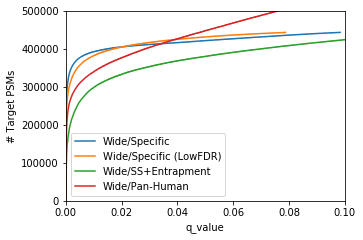

In [16]:
fig,ax = plt.subplots(figsize=default_figsize)

for ((df, info), label) in zip(data, labels):
    pd.concat([(~df.decoy).cumsum().rename('target'), df['q_value'].astype('float64')], axis=1).plot.line(x='q_value', y='target', ax=ax, label=label)

ax.set_ylabel('# Target PSMs')
ax.set_xlim(0, 0.1)
ax.set_ylim(0, 5e5)

fig.savefig('target/img/psms-roc.pdf', bbox_inches='tight')

In [17]:
defaultbins=50

def plot_hist(series, xlabel=None, ylabel='# PSMs' if analyze_psms else '# Peptides', ax=None, bins=defaultbins, **kwds):
    if ax is None:
        fig,ax = plt.subplots()
    
    ax.set_yscale('log')
    ax.set_ylabel(ylabel)
    
    if xlabel:
        ax.set_xlabel(xlabel)
        
    return ax.hist(np.float64(series), bins=bins, **kwds)

def plot_multi_dists(data, labels, col='p_value', xlabel='$p$-value', pi0_key='pi_0_psms', bins=defaultbins, alpha=0.5, sharex=True, xlim=None, vlines=[]):
    fig, axes = plt.subplots(len(data), 1
                         ,figsize=(default_figsize[0], (1+len(data))/2*default_figsize[1])
                         ,sharex=sharex
                        )

    for (df, info), title, ax in zip(data, labels, axes):
        tgtmask = ~df.decoy
        decmask = df.decoy

        tgtvals, tgtbins, tgtpatches = plot_hist(df[tgtmask][col], ax=ax, bins=bins, label='Target')
        plot_hist(df[decmask][col], ax=ax, bins=bins, alpha=alpha, label='Decoy')

        pi0 = float(info[pi0_key])
        tft = tgtmask.sum()*pi0/bins

        if xlim is None:
            xmin, xmax = tgtbins[0], tgtbins[-1]
        else:
            xmin, xmax = xlim
            
        ax.set_xlim(xmin, xmax)
        
        ax.hlines([tft], xmin, xmax, color='tab:red', linestyle='--', linewidth=1, label='Theo. False Tgt.')
        if vlines and len(vlines):
            ax.vlines(vlines, 0, max(tgtvals), color='k', linestyle='--', linewidth=1)

        ax.text(xmax, tft, '$\pi_0={:.1f}\%$'.format(100*pi0), va='bottom', ha='right', fontsize='small')

        ax.set_title(title, fontdict={'fontsize': 'medium'})
    axes[0].legend(loc='upper left', framealpha=alpha, fontsize='small')    
    axes[len(data) - 1].set_xlabel(xlabel)

    fig.suptitle("Distribution of {:s}s".format(xlabel))

    fig.tight_layout(rect=(0,0,1,.97))
    
    return fig

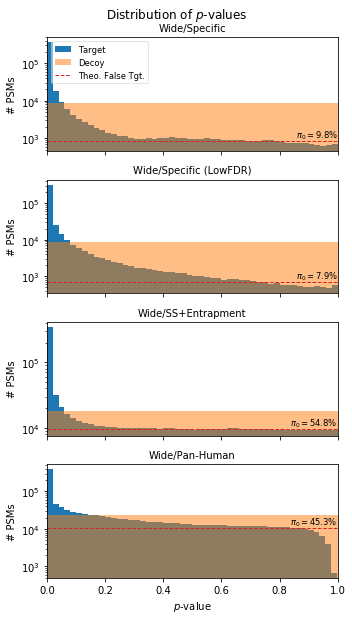

In [18]:
fig = plot_multi_dists(data, labels, xlim=(0,1))
fig.savefig('target/img/{:s}-p-vals.pdf'.format('psms' if analyze_psms else 'peptides'), bbox_inches='tight')

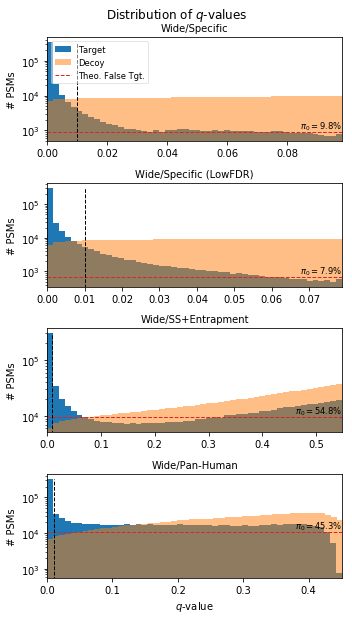

In [19]:
fig = plot_multi_dists(data, labels, col='q_value', xlabel='$q$-value', sharex=False, vlines=[0.01])
fig.savefig('target/img/{:s}-q-vals.pdf'.format('psms' if analyze_psms else 'peptides'), bbox_inches='tight')

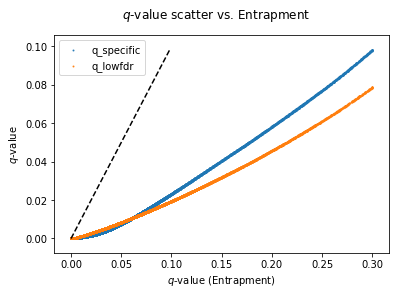

In [20]:
scatter_data = map(
  lambda data,*tail: (
        data[0][~data[0].decoy & (~data[0].entrap if 'entrap' in data[0].columns else True)]
      , *tail
    )
  , [specific_data, entrap_data, lowfdr_data]
)

def to_series(x):
    data,label = x
    return data[0].sort_values('psm_id')['q_value'].rename(label).astype('float64')

scatter_df = pd.concat(
    map(
        to_series
      , zip(scatter_data, ['q_specific', 'q_entrap', 'q_lowfdr'])
    )
  , axis=1
)

fig,ax = plt.subplots()

kwds = {
    's':     1
  , 'alpha': 0.85
}

scatter_df.plot.scatter(
    ax=ax
  , x='q_entrap'
  , y='q_specific'
  , label='q_specific'
  , c='tab:blue'
  , **kwds
)
scatter_df.plot.scatter(
    ax=ax
  , x='q_entrap'
  , y='q_lowfdr'
  , label='q_lowfdr'
  , c='tab:orange'
  , **kwds
)

m = min(scatter_df['q_specific'].max(), scatter_df['q_entrap'].max())
trend = 1
ax.plot([0, m], [0, m*trend], 'k--')

ax.set_xlabel('$q$-value (Entrapment)')
ax.set_ylabel('$q$-value')

fig.suptitle('$q$-value scatter vs. Entrapment')

fig.savefig('target/img/q-val-scatter.png', bbox_inches='tight')